In [1]:
PATH_TO_BHPTNRSur = "/home/ubuntu/EG-CA/BHPTNRSurrogate"
import numpy as np
import matplotlib.pyplot as plt
import sys
# add the path to the script directory
sys.path.append(PATH_TO_BHPTNRSur)
from surrogates import BHPTNRSur1dq1e4 as bhptsur

cannot import LAL
**** Surrogate loaded: BHPTNRSur1dq1e4 ****


(1.6517080059846327e-23-6.083120559363303e-34j)


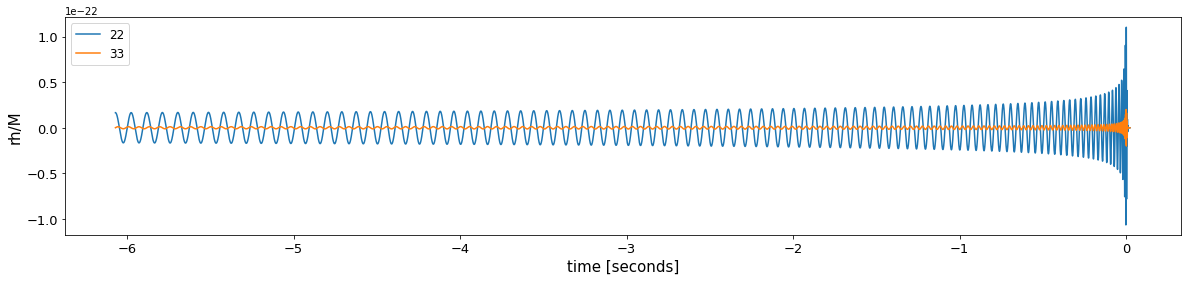

In [2]:
tsur, hsur = bhptsur.generate_surrogate(q=2.5, M_tot=60, dist_mpc=10000)
print(hsur[(2,2)][0])

#print(hsur.keys())

plt.figure(figsize=(20,4))
plt.plot(tsur, np.real(hsur[(2,2)]), '-', label='22')
plt.plot(tsur, np.real(hsur[(3,3)]), '-', label='33')
plt.xlabel('time [seconds]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
plt.show()

In [3]:
"python3 generate_bhpt_dataset.py --n-samples 256  --q-min 2.5 --q-max 10.0"

import torch
import torch.nn as nn
import architectures as arch
from functools import partial
import argparse
from pathlib import Path
from torchvision.ops import MLP
from running import train_one_epoch, evaluate_refinement
from data import setup_waveform_dataloaders, WaveformDataset, load_bhpt_tensors
from architectures import SingleConvNeuralNet, GalerkinTransformer
from bhpt_running import train_one_epoch, evaluate_refinement

parser = argparse.ArgumentParser(description="BHPT training script (core logic excerpt).")
parser.add_argument("--data", type=Path, default=Path("bhpt_dataset.pt"), help="Path to the .mat dataset produced by generate_bhpt_dataset.py.")
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--batch-size", type=int, default=8)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--weight-decay", type=float, default=1e-4, help="Weight decay (L2 penalty) for Adam optimizer.")
parser.add_argument("--n-timesteps", type=int, default=None, help="Number of temporal frames to sample from the raw data (consistent with notebook).")

parser.add_argument("--share", action="store_true", help="Share weights between modules.")
parser.add_argument("--no-share", dest="share", action="store_false", help="Don't share weights between modules.")
parser.set_defaults(share=True)

parser.add_argument("--refinement", action="store_true", help="Use refinement.")
parser.add_argument("--no-refinement", dest="refinement", action="store_false", help="Don't use refinement.")
parser.set_defaults(refinement=True)

parser.add_argument("--picard", action="store_true", help="Use Picard iterations.")
parser.add_argument("--no-picard", dest="picard", action="store_false", help="Don't use Picard iterations.")
parser.set_defaults(picard=True)

parser.add_argument("--d_model", type=int, default=63)
parser.add_argument("--nhead", type=int, default=4)
parser.add_argument("--dim_feedforward", type=int, default=64)
parser.add_argument("--dropout", type=float, default=0.1)
parser.add_argument("--n_layers", type=int, default=4)
parser.add_argument("--n_modules", type=int, default=1)
parser.add_argument("--q", type=int, default=1)
parser.add_argument("--r", type=float, default=0.5)

args = parser.parse_args("")

Interactive environ: Jupyter themes not found.


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load data from the .pt file into two tensors
waveforms_tensor, params_tensor = load_bhpt_tensors(
    args.data, n_timesteps=args.n_timesteps
)

# 2. Create DataLoaders from the tensors
train_loader, val_loader = setup_waveform_dataloaders(
    waveforms=waveforms_tensor.to(device),
    params=params_tensor.to(device),
    batch_size=args.batch_size
)

# 3. Define dimensions for the model
P = 3  # Positional encoding dimensions (t, y, x)
N, T, H, W, Q = waveforms_tensor.shape
_, n_params = params_tensor.shape

print("DataLoaders are ready.")



Using device: cuda
Loading data from bhpt_dataset.pt...
  Loaded 'waveforms' with shape: torch.Size([50, 153075, 1, 1, 2])
  Loaded 'params' with shape: torch.Size([50, 1])
Final tensor shapes: waveforms=torch.Size([50, 153075, 1, 1, 2]), params=torch.Size([50, 1])
DataLoaders are ready.


In [6]:
# Cell 3: Model Definition
# For waveform data (H=1, W=1), the "convolution" is just a linear projection.
# Kernel size K and stride S are (1,1).

encoder_out_dim = args.d_model - P

encoder = SingleConvNeuralNet(dim=Q,
    hidden_dim=args.d_model - P,
    out_dim=args.d_model - P,
    hidden_ff=128,
    K=[1, 1],
    S=[1, 1])

encoder = encoder.to(device)

# Dummy forward pass to get the shape for the decoder
with torch.no_grad():
    sample_waveforms = waveforms_tensor[0, None, ...].to(device)
    _, _, H_prime, W_prime, _ = encoder.forward(sample_waveforms).shape
# The decoder's input channels depend on the encoder's output shape
decoder_in_channels = H_prime * W_prime * encoder_out_dim

# The total dimension fed to the transformer will be d_model + n_params
d_model_conditioned = args.d_model + n_params

if args.refinement:
    make_module = partial(arch.GalerkinTransformer,
                          d_model=d_model_conditioned,
                          nhead=args.nhead,
                          dim_feedforward=args.dim_feedforward,
                          dropout=args.dropout,
                          n_layers=args.n_layers)
    process_trajectory = arch.broadcast_initial_conditions
else:
    # Autoregressive training is not implemented for the BHPT case yet
    raise NotImplementedError("Only refinement mode is set up for BHPT training.")

if args.share:
    modules = arch.make_weight_shared_modules(make_module, n_modules=args.n_modules)
else:
    modules = arch.make_weight_unshared_modules(make_module, n_modules=args.n_modules)

if args.picard:
    model = arch.PicardIterations(modules, q=args.q, r=args.r)
else:
    model = arch.ArbitraryIterations(modules)
model = model.to(device)


decoder = MLP(
    in_channels=decoder_in_channels,
    hidden_channels=[64, 256, H * W * Q], # Final output must match original H, W, Q
    activation_layer=nn.ELU,
)

decoder = decoder.to(device)

print(f"Model, Encoder, and Decoder are on device: {next(model.parameters()).device}")
print(f"Transformer d_model: {d_model_conditioned} (divisible by nhead={args.nhead})")

Model, Encoder, and Decoder are on device: cuda:0
Transformer d_model: 64 (divisible by nhead=4)


/usr/lib/python3/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


In [7]:
# The optimizer needs to know about all trainable parameters
all_params = list(model.parameters()) + list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.Adam(all_params, lr=args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=args.epochs)

print("Starting training...")
for epoch in range(1, args.epochs + 1):
    # Pass nhead to the training and evaluation functions
    train_loss = train_one_epoch(model,
                                 encoder,
                                 decoder,
                                 process_trajectory,
                                 train_loader,
                                 optim)
                                 
    val_loss = evaluate_refinement(model,
                                   encoder,
                                   decoder,
                                   process_trajectory,
                                   val_loader)
    scheduler.step()
    print(f"Epoch {epoch:3d} | train loss: {train_loss:.6f} | val loss: {val_loss:.6f}")

torch.save({"state_dict": model.state_dict()}, Path("bhpt_weights.pt"))
print("\nTraining complete. Saved model weights to bhpt_weights.pt")

Starting training...
Epoch   1 | train loss: 170.779436 | val loss: 95.381905
Epoch   2 | train loss: 69.865382 | val loss: 62.815376
Epoch   3 | train loss: 40.624896 | val loss: 19.219030
Epoch   4 | train loss: 19.135119 | val loss: 6.856436
Epoch   5 | train loss: 12.573715 | val loss: 0.382673
Epoch   6 | train loss: 3.199841 | val loss: 2.701567
Epoch   7 | train loss: 1.288960 | val loss: 0.526713
Epoch   8 | train loss: 1.047466 | val loss: 0.570589
Epoch   9 | train loss: 0.429501 | val loss: 0.063126
Epoch  10 | train loss: 0.040432 | val loss: 0.030268

Training complete. Saved model weights to bhpt_weights.pt
